IMPORTING NECESSARY LIBRARIES

In [ ]:
#Making necessary imports 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.corpus import opinion_lexicon
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
sns.set_style("whitegrid")

print("Imports done")

UPDATED FEATURE ENGINEERING PIPELINE
Loaded 834 articles.


100%|██████████| 834/834 [00:02<00:00, 300.07it/s]


Handcrafted features shape: (834, 23)
Final feature matrix shape: (834, 49)

Generating Word Clouds...


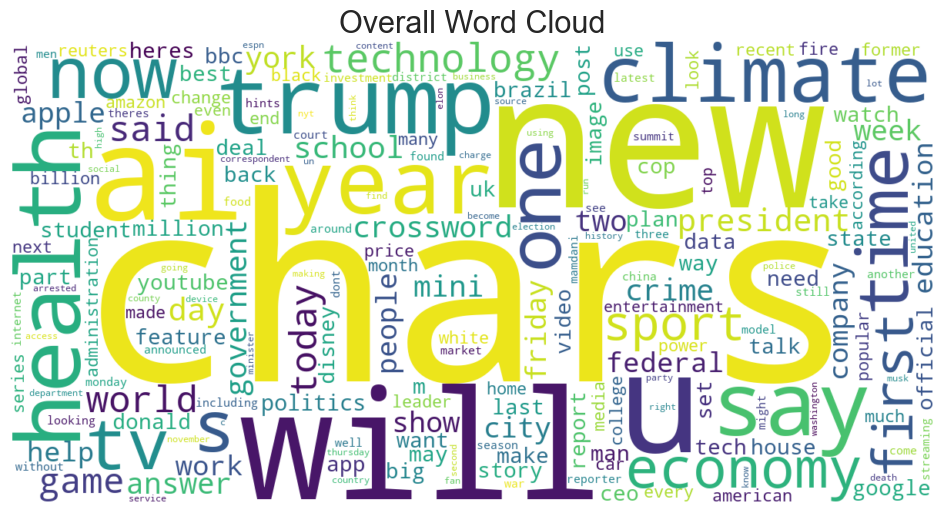

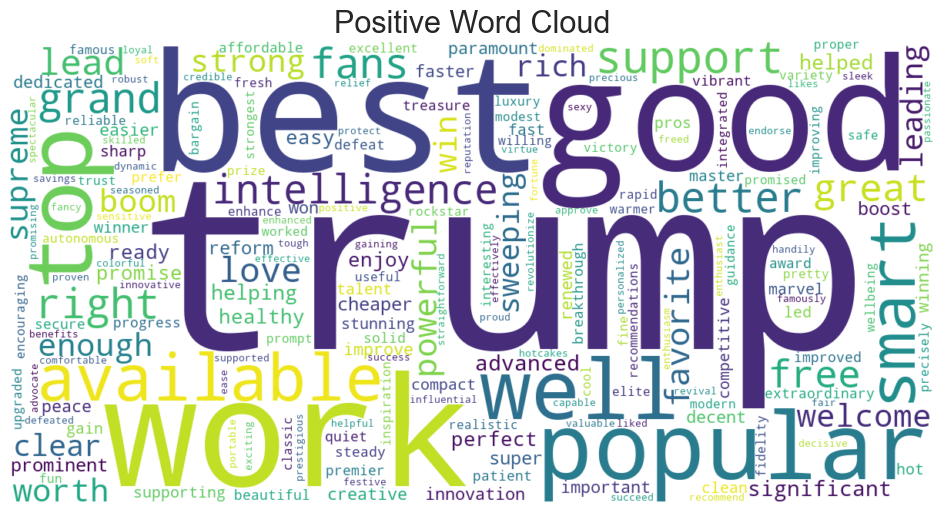

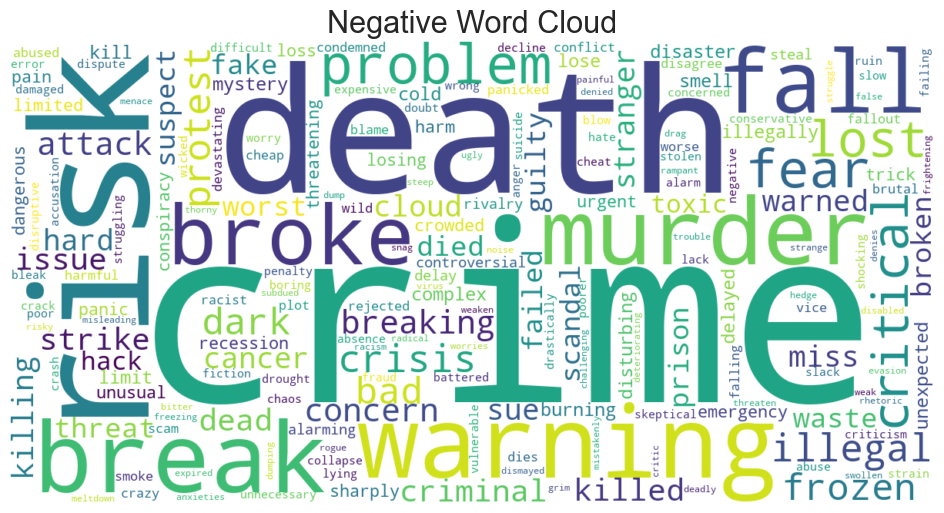

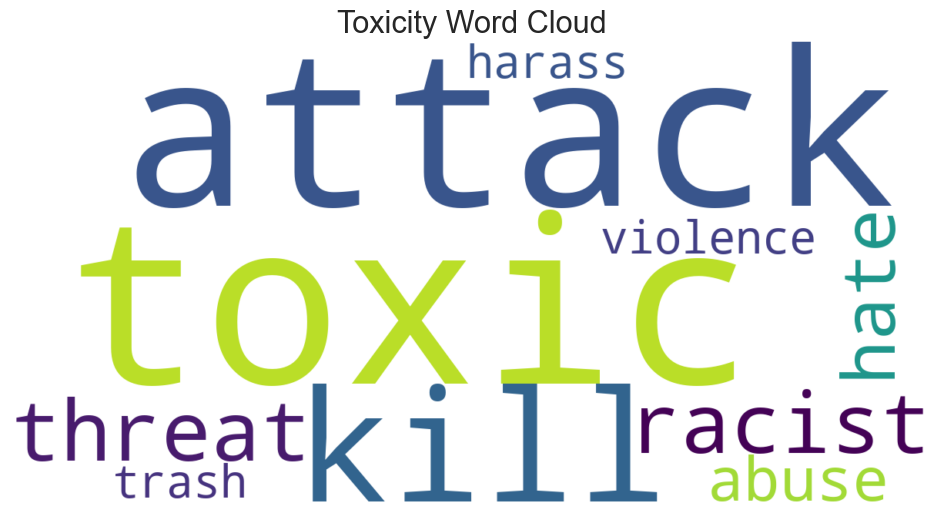

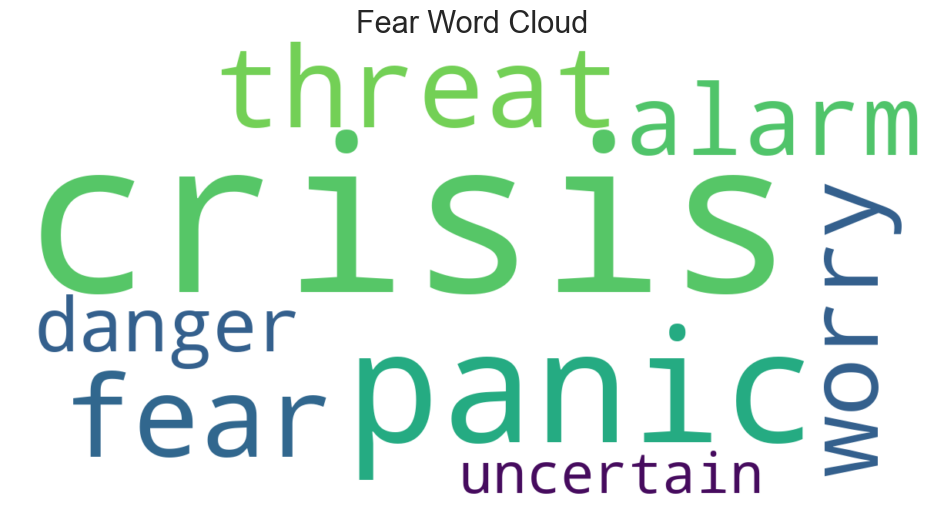

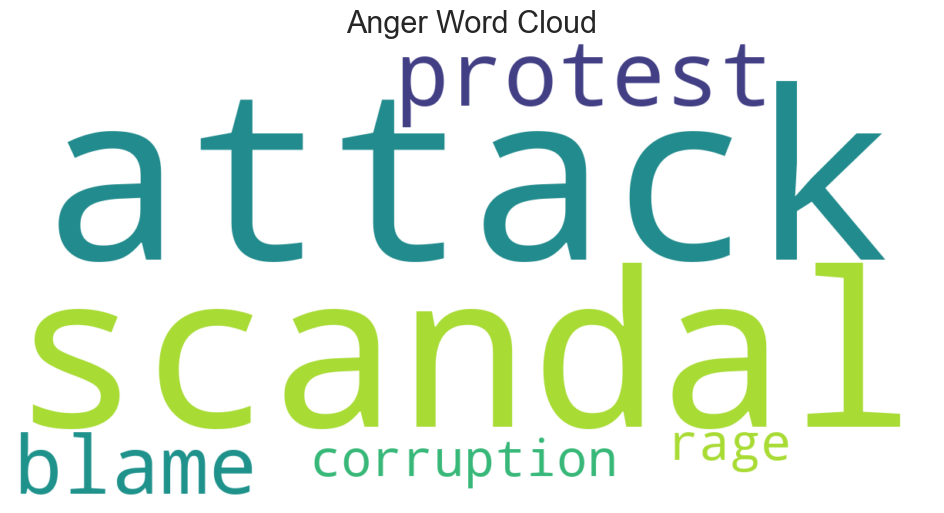

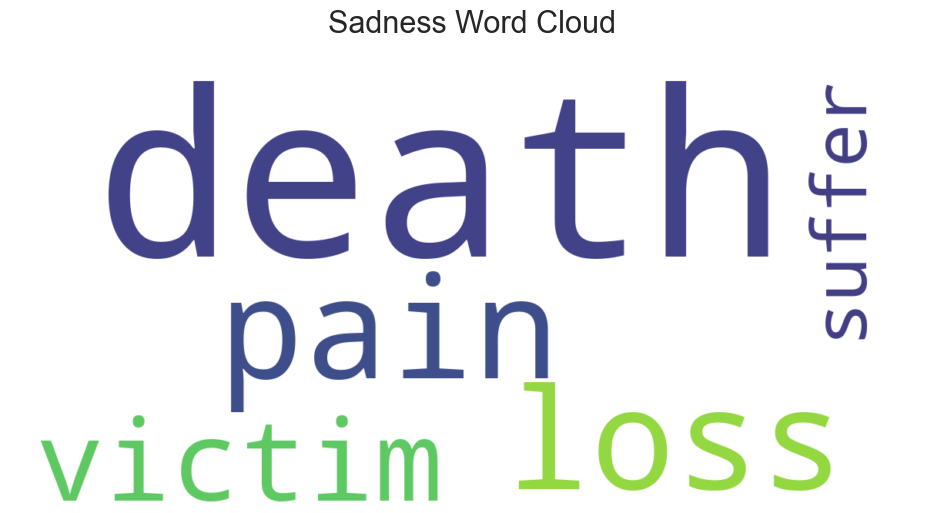

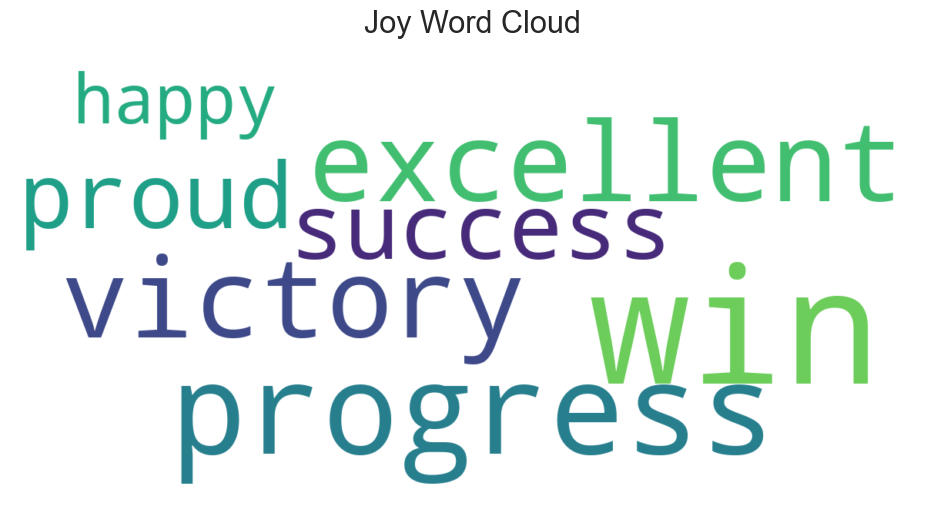

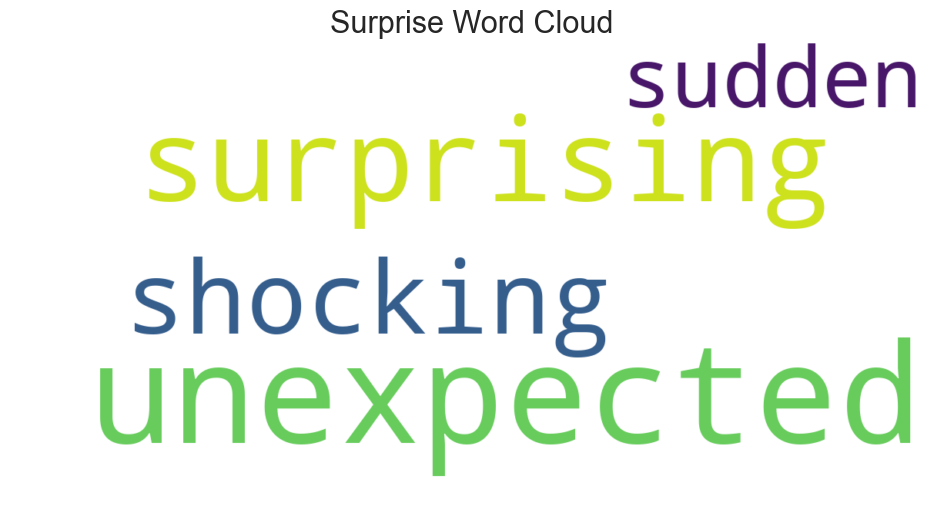

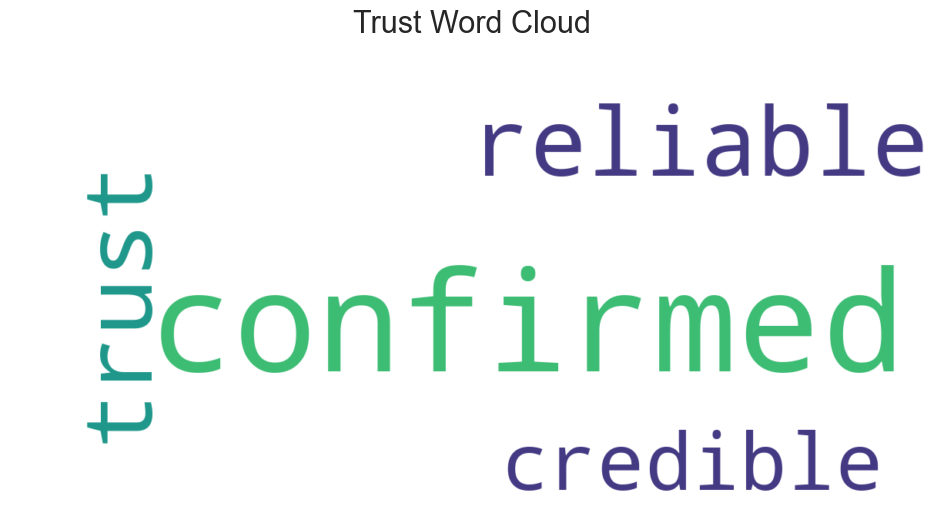

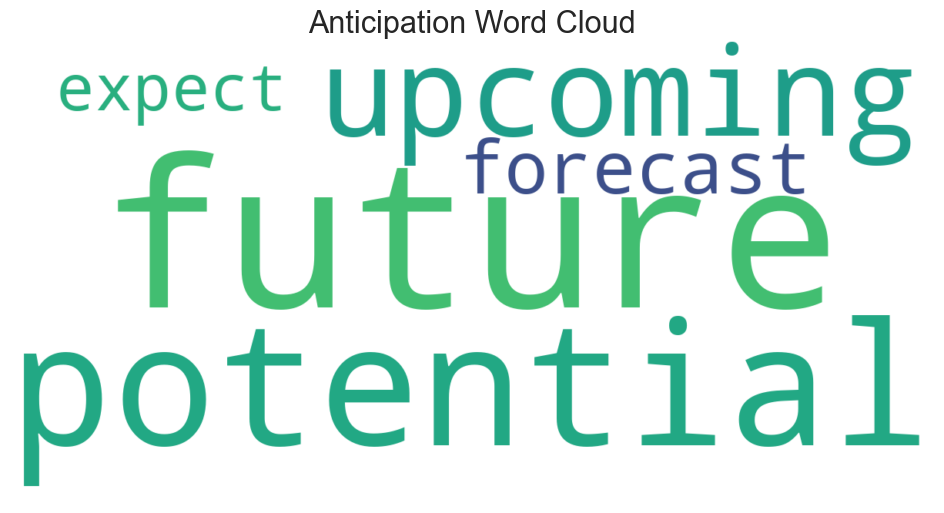

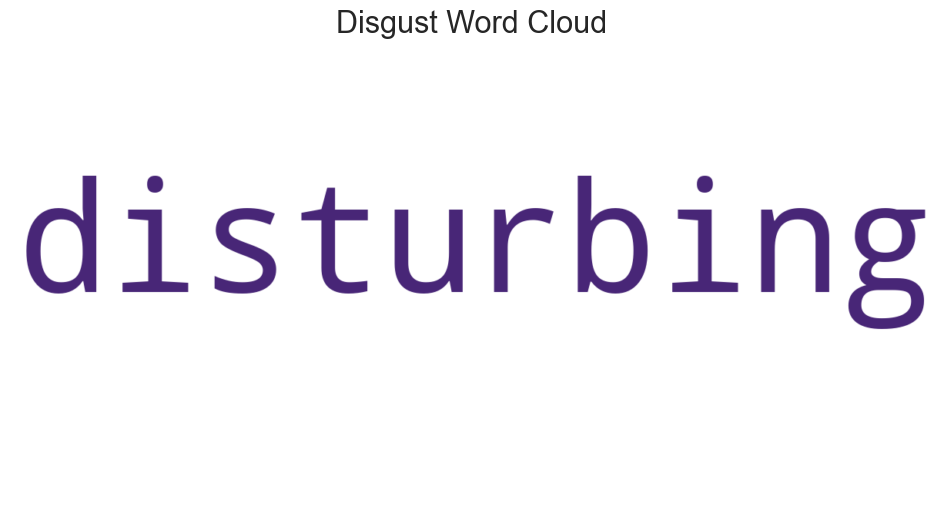


FEATURES USED IN THE MODEL
fear_count
fear_ratio
anger_count
anger_ratio
sadness_count
sadness_ratio
joy_count
joy_ratio
surprise_count
surprise_ratio
trust_count
trust_ratio
anticipation_count
anticipation_ratio
disgust_count
disgust_ratio
pos_word_count
neg_word_count
pos_ratio
neg_ratio
sentiment_balance
toxicity_count
toxicity_ratio
vader_compound
vader_pos
vader_neg
vader_neu
svd_1
svd_2
svd_3
svd_4
svd_5
svd_6
svd_7
svd_8
svd_9
svd_10
svd_11
svd_12
svd_13
svd_14
svd_15
svd_16
svd_17
svd_18
svd_19
svd_20
dominant_emotion
sentiment_category

Total features used: 49

📊 ADVANCED FEATURE VISUALIZATIONS


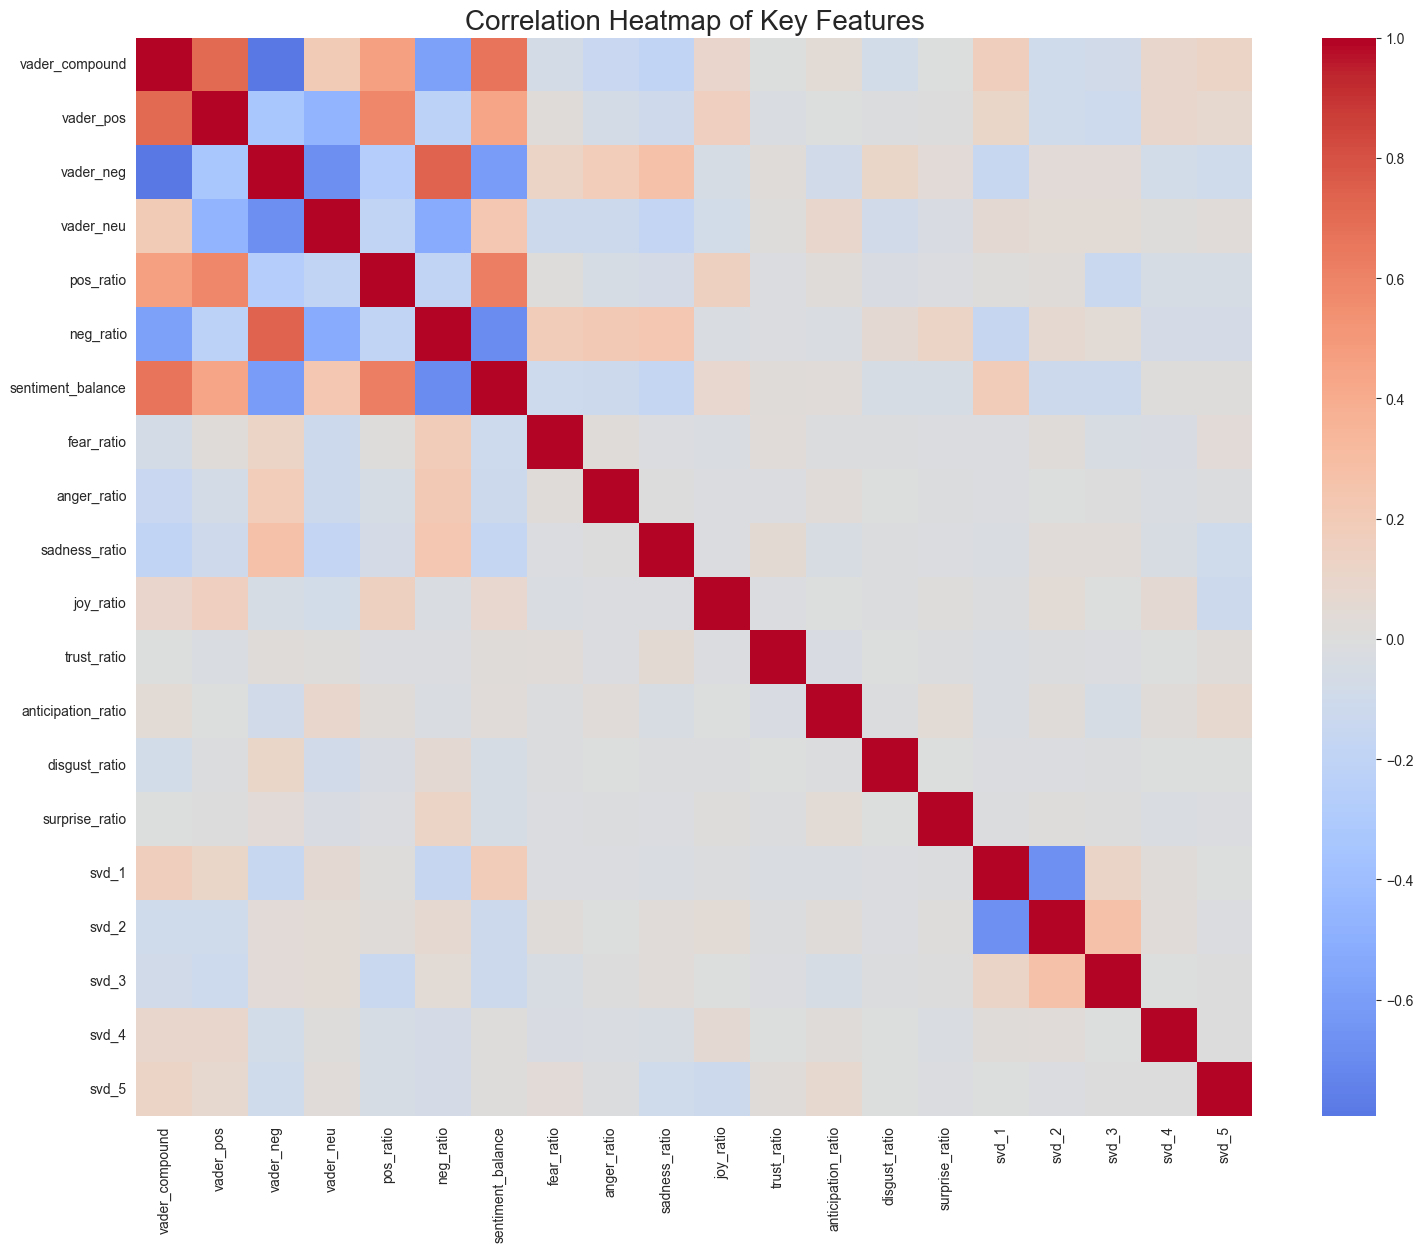

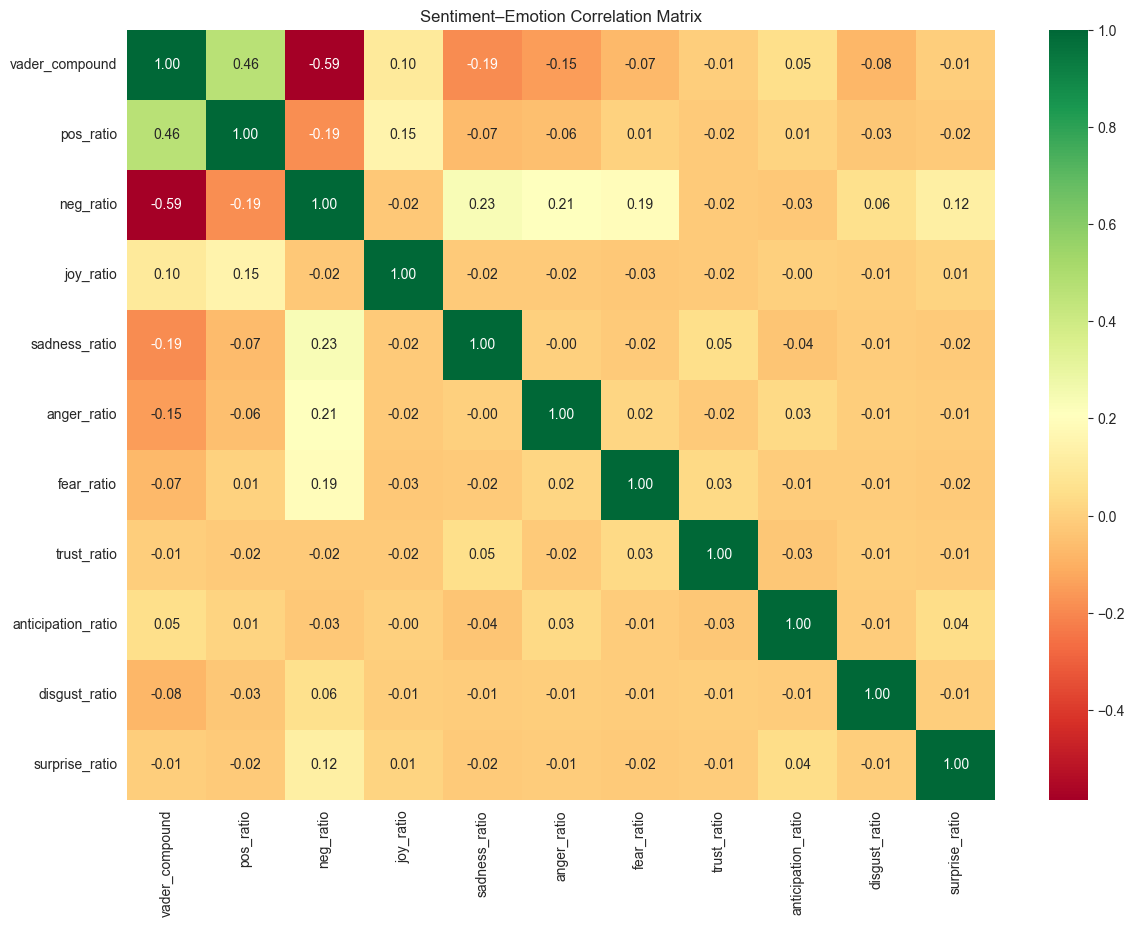

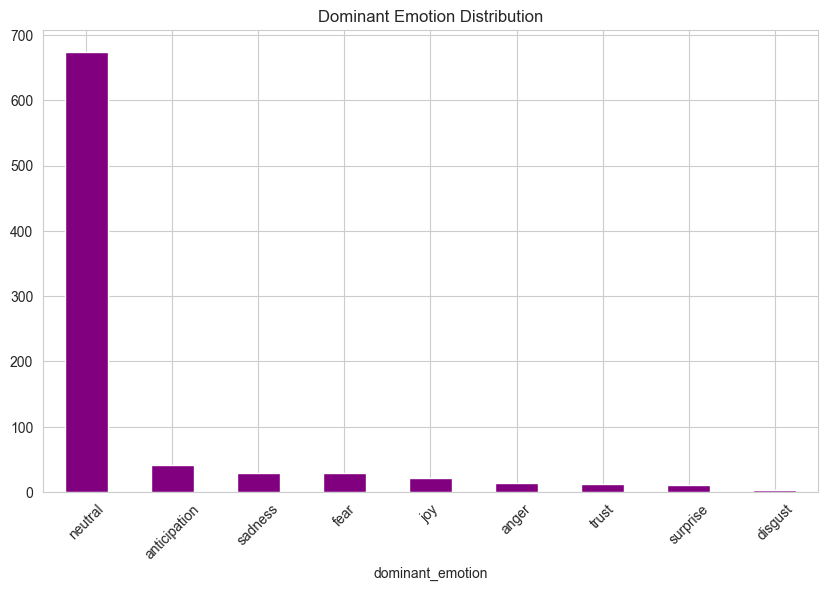

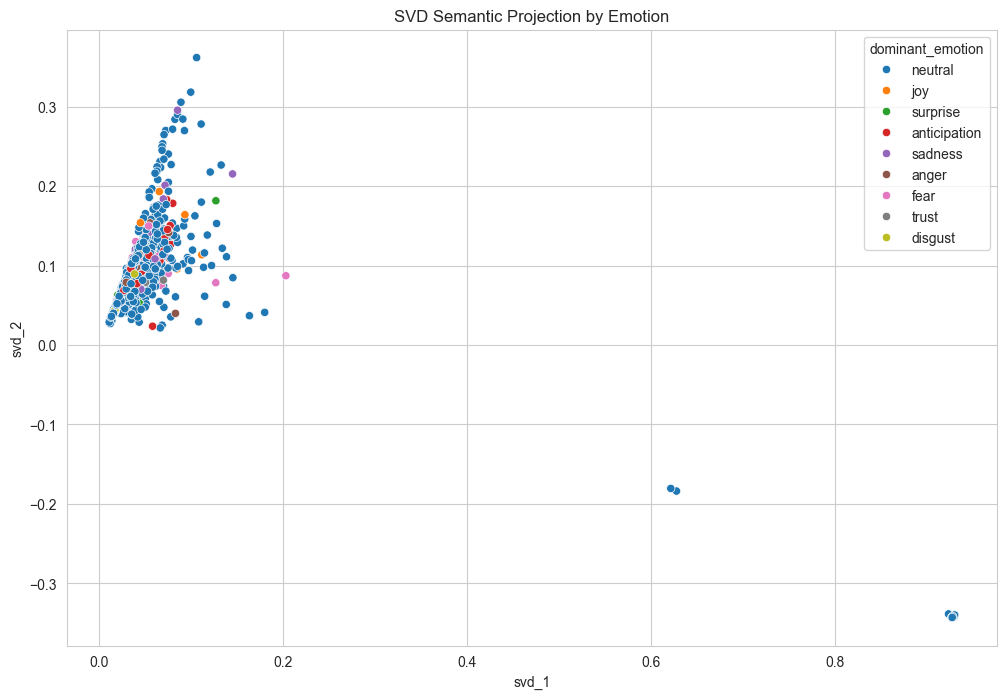

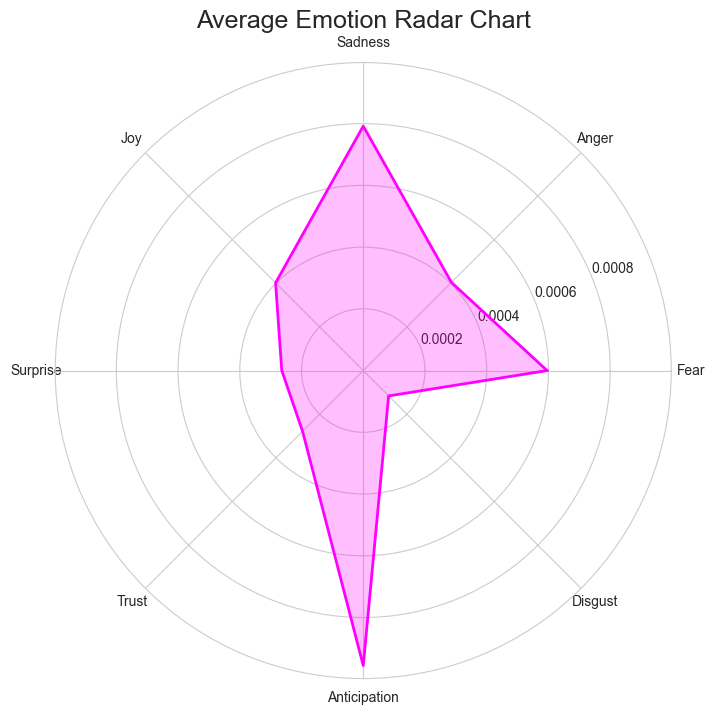

✅ All features successfully saved!
📁 Saved to: ../data/engineered_featurescsv


In [ ]:


#Downloading required lexicons 
nltk.download("opinion_lexicon", quiet=True)

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Added lightweight toxicity lexicon (allowed: no ML, no DL)
toxicity_words = {
    "hate","idiot","stupid","racist","toxic","abuse","threat",
    "kill","attack","violence","trash","filthy","harass","insult",
}

emotion_lexicons = {
    'fear': {'threat','danger','crisis','panic','fear','worry','scared','terror','uncertain','alarm'},
    'anger': {'angry','rage','furious','corruption','scandal','violation','blame','attack','protest'},
    'sadness': {'sad','grief','loss','death','hurt','victim','suffer','pain','tragic','mourning'},
    'joy': {'happy','joy','delight','victory','success','win','proud','excellent','progress'},
    'surprise': {'unexpected','shocking','astonishing','sudden','surprising'},
    'trust': {'trust','reliable','credible','confirmed','authentic','verified'},
    'anticipation': {'expect','anticipate','forecast','future','upcoming','prepare','potential'},
    'disgust': {'disgust','repulsive','disturbing','horrible','appalling'}
}


#Taking and loading the cleaned dataset
df = pd.read_csv("../data/cleaned_news_data.csv")
df["cleaned_text"] = df["cleaned_text"].fillna("")

# ensure token column exists
if "tokens_str" in df.columns:
    df["tokens"] = df["tokens_str"].apply(lambda x: x.split() if pd.notna(x) else [])
else:
    df["tokens"] = df["cleaned_text"].apply(lambda x: x.split())

print(f"Loaded {len(df)} articles.")


#Creating function to check emotion features
#Creating lexicons 
def extract_emotion_features(tokens):
    tokens = [t.lower() for t in tokens]
    total = len(tokens)

    feats = {}
    for emo, lex in emotion_lexicons.items():
        count = sum(t in lex for t in tokens)
        feats[f"{emo}_count"] = count
        feats[f"{emo}_ratio"] = (count / total) if total > 0 else 0
    return feats


#Doing sentiment lexicon features
#Taking the following word count and ratio to check positive and negative sentiment
def extract_sentiment_lexicon_features(tokens):
    tokens = [t.lower() for t in tokens]
    total = len(tokens)

    pos_count = sum(t in positive_words for t in tokens)
    neg_count = sum(t in negative_words for t in tokens)

    if pos_count + neg_count == 0:
        balance = 0
    else:
        balance = (pos_count - neg_count) / (pos_count + neg_count)

    return {
        "pos_word_count": pos_count,
        "neg_word_count": neg_count,
        "pos_ratio": pos_count / total if total > 0 else 0,
        "neg_ratio": neg_count / total if total > 0 else 0,
        "sentiment_balance": balance
    }


#Creating fucntion to check the toxicity feautres
#Mainly for negative features and sentiments 
def extract_toxicity_features(tokens):
    tokens = [t.lower() for t in tokens]
    total = len(tokens)

    tox_count = sum(t in toxicity_words for t in tokens)
    return {
        "toxicity_count": tox_count,
        "toxicity_ratio": tox_count / total if total > 0 else 0
    }


#Using vader for intial sentiment analysis
vader = SentimentIntensityAnalyzer()

def extract_vader(text):
    text = str(text)
    if not text.strip():
        return pd.Series({"vader_compound": 0, "vader_pos": 0, "vader_neg": 0, "vader_neu": 0})
    s = vader.polarity_scores(text)
    return pd.Series({
        "vader_compound": s["compound"],
        "vader_pos": s["pos"],
        "vader_neg": s["neg"],
        "vader_neu": s["neu"],
    })


#Building the final features
def build_all_features(tokens):
    return {
        **extract_emotion_features(tokens),
        **extract_sentiment_lexicon_features(tokens),
        **extract_toxicity_features(tokens),
    }

handcrafted_df = df["tokens"].progress_apply(build_all_features).apply(pd.Series)
vader_df = df["cleaned_text"].progress_apply(extract_vader)

print(f"Handcrafted features shape: {handcrafted_df.shape}")


#Using tf-idf because it is text features
tfidf = TfidfVectorizer(
    max_features=3000,  
    stop_words="english",
    lowercase=True,
    strip_accents="unicode"
)

X_tfidf = tfidf.fit_transform(df["cleaned_text"])

svd = TruncatedSVD(n_components=20, random_state=42)   
X_svd = svd.fit_transform(X_tfidf)

svd_df = pd.DataFrame(X_svd, columns=[f"svd_{i+1}" for i in range(20)])


#Merging all features
final_features = pd.concat([handcrafted_df, vader_df, svd_df], axis=1)

emotion_count_cols = [f"{emo}_count" for emo in emotion_lexicons.keys()]  

max_emotion_count = final_features[emotion_count_cols].max(axis=1)

final_features["dominant_emotion"] = (
    final_features[emotion_count_cols].idxmax(axis=1).str.replace("_count","")
)

final_features.loc[max_emotion_count == 0, "dominant_emotion"] = "neutral"

# sentiment category
final_features["sentiment_category"] = "Neutral"
final_features.loc[final_features["vader_compound"] > 0.1, "sentiment_category"] = "Positive"
final_features.loc[final_features["vader_compound"] < -0.1, "sentiment_category"] = "Negative"

print(f"Final feature matrix shape: {final_features.shape}")


#Creating word clouds for visualziations
print("\nGenerating Word Clouds...")

all_text = " ".join(df["cleaned_text"].astype(str)).lower()
tokens_all = all_text.split()

pos_cloud = " ".join([w for w in tokens_all if w in positive_words])
neg_cloud = " ".join([w for w in tokens_all if w in negative_words])
tox_cloud = " ".join([w for w in tokens_all if w in toxicity_words])

emotion_clouds = {
    emo: " ".join([w for w in tokens_all if w in lex])
    for emo, lex in emotion_lexicons.items()
}

def show_wordcloud(text, title):
    if not text.strip():
        print(f"No words for {title}")
        return
    wc = WordCloud(width=1200, height=600, background_color="white",
                   stopwords=STOPWORDS, collocations=False).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=22)
    plt.show()


show_wordcloud(all_text, "Overall Word Cloud")
show_wordcloud(pos_cloud, "Positive Word Cloud")
show_wordcloud(neg_cloud, "Negative Word Cloud")
show_wordcloud(tox_cloud, "Toxicity Word Cloud")

for emo, txt in emotion_clouds.items():
    show_wordcloud(txt, f"{emo.capitalize()} Word Cloud")


#Printign the possible features
print("\n==============================")
print("FEATURES USED IN THE MODEL")
print("==============================")

for f in final_features.columns:
    print(f)

print(f"\nTotal features used: {len(final_features.columns)}")


#Advanced features

print("\n" + "="*70)
print("ADVANCED FEATURE VISUALIZATIONS")
print("="*70)

# 1. Correlation Heatmap
heatmap_features = [
    "vader_compound","vader_pos","vader_neg","vader_neu",
    "pos_ratio","neg_ratio","sentiment_balance",
    "fear_ratio","anger_ratio","sadness_ratio","joy_ratio",
    "trust_ratio","anticipation_ratio","disgust_ratio","surprise_ratio",
    "svd_1","svd_2","svd_3","svd_4","svd_5"
]

existing = [c for c in heatmap_features if c in final_features.columns]

plt.figure(figsize=(18, 14))
sns.heatmap(final_features[existing].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Key Features", fontsize=20)
plt.show()

# 2. Sentiment vs Emotion Heatmap
sent_emo_cols = [
    "vader_compound","pos_ratio","neg_ratio",
    "joy_ratio","sadness_ratio","anger_ratio","fear_ratio",
    "trust_ratio","anticipation_ratio","disgust_ratio","surprise_ratio"
]

cols = [c for c in sent_emo_cols if c in final_features]

plt.figure(figsize=(14, 10))
sns.heatmap(final_features[cols].corr(), annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Sentiment–Emotion Correlation Matrix")
plt.show()

# 3. Dominant Emotion Distribution
plt.figure(figsize=(10, 6))
final_features["dominant_emotion"].value_counts().plot(kind="bar", color="purple")
plt.title("Dominant Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

# 4. SVD Scatter (Semantic Clusters)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final_features, x="svd_1", y="svd_2",
                hue=final_features["dominant_emotion"], palette="tab10")
plt.title("SVD Semantic Projection by Emotion")
plt.show()

# 5. Emotion Radar Chart
emo_ratios = [f"{e}_ratio" for e in emotion_lexicons.keys()]
emo_ratios = [c for c in emo_ratios if c in final_features]

means = final_features[emo_ratios].mean().values
labels = [c.replace("_ratio", "").capitalize() for c in emo_ratios]

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
means = np.concatenate((means, [means[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, means, linewidth=2, color="magenta")
ax.fill(angles, means, alpha=0.25, color="magenta")
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Average Emotion Radar Chart", fontsize=18)
plt.show()

output_path = "../data/engineered_featurescsv"
final_features.to_csv(output_path, index=False)


print("All features successfully saved!")
print(f"Saved to: {output_path}")

